PROGETTO MACHINE LEARNING STROKE PREDICTION

DESCRIZIONE 

Secondo l'Organizzazione Mondiale della Sanità (OMS), l'ictus è la seconda causa di morte a livello globale, responsabile di circa l'11% dei decessi totali. Questo set di dati viene utilizzato per prevedere se un paziente rischia di essere colpito da ictus in base a parametri di input come il sesso, l'età, varie malattie e lo stato di fumatore. Ogni riga dei dati fornisce informazioni rilevanti sul paziente.
Gli obiettivi di questo progetto sono:
- Capire dai dati forniti quali sono le ragioni che causano un ictus nelle persone;
- Predirre la probabilità di un ictus.


IMPORTAZIONI E EDA (EXPLORING DATA ANALYSIS)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Warnings.
import warnings
warnings.filterwarnings("ignore")

from matplotlib.pyplot import figure
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
import matplotlib.gridspec as gridspec
from imblearn.over_sampling import SMOTE

# Color Palette.
palette = sns.husl_palette(h=.5)
palette_matrix = sns.color_palette("light:#5A9", as_cmap=True)

#Lettura file CSV (nostro dataset)
ds_stroke = pd.read_csv('dataset/healthcare-dataset-stroke-data.csv' ,\
     index_col = False , sep=',')
cols = ds_stroke.columns.values

print(ds_stroke.shape)
print(ds_stroke.info())
print(ds_stroke.describe())
#print(ds_stroke.head(3))
print(cols)



(5110, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   3651

Il Dataset Stroke è costituito da 11 features, 5110 campioni e dalla label stroke. Fin da subito controlliamo se nel dataset sono presenti elementi nulli e se sono presenti righe duplicate. Possiamo vedere come ci siano 201 valori della colosvma "bmi" contenente elementi nulli che bisogna opportunatamente gestire, mentre non ci sono campioni duplicati.
Inoltre, guardando l'output della info() possiamo notare come 5 delle 12 features siano di tipo object. Successivamente verificheremo i valori assunti da tali features e se sia il caso di eseguire una dummizzazione.

In [3]:
#Drop della colonna "id" perché serve semplicemente a identificare un paziente
ds_stroke = ds_stroke.drop('id', axis=1)
#print(ds_stroke.info())
print(ds_stroke.duplicated().sum())
print(ds_stroke.isnull().sum())


0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Per la gestione dei NaN nella colonna ibm ho preferito sostituire i valori mancanti con la media dei valori presenti in quella colonna, invece di droppare direttamente le righe per evitare la perdita di informazioni.

In [4]:
#sostituzioni valori NaN
ds_stroke.bmi.fillna(ds_stroke.bmi.mean(),inplace=True)
#Check elementi nulli dataset dopo sostituzione
print(ds_stroke.isnull().sum())
print(ds_stroke.head())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64
   gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level        bmi   smoking_status  stroke  
0          Urban             228.69  36.600000  formerly smoked       1  
1          Rural             202.21  28.893237     never smoked       1  
2          Rural             105.92  32.500000     neve

Una delle feature di tipo object è la colosvma "gender". Ora vado a controllare i valori assunti da questa feature.

['Male' 'Female' 'Other']
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64


<Axes: xlabel='gender', ylabel='Count'>

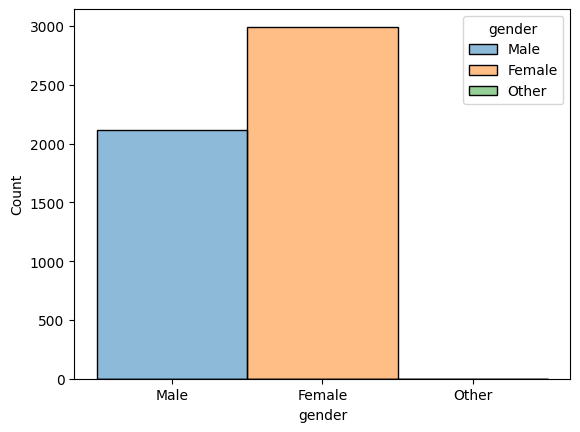

In [5]:
print(ds_stroke['gender'].unique())
print(ds_stroke['gender'].value_counts())

#Istogramma
sns.histplot(data=ds_stroke , hue="gender" , x = 'gender')


Dato che tra tutti i valori assunti da gender c'è nè solo uno che assume valore Other decido di dropparlo perchè non c'è una perdita significativa di informazioni.

<Axes: xlabel='gender', ylabel='Count'>

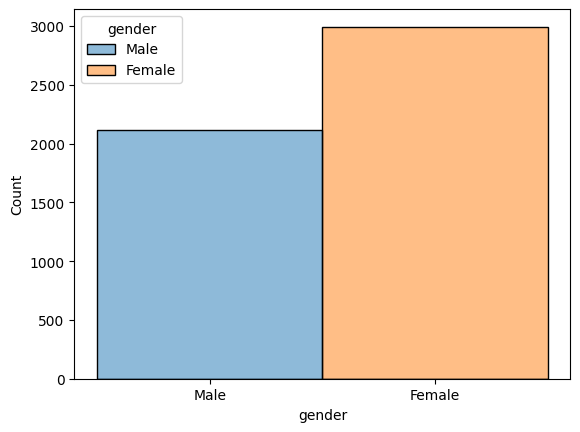

In [6]:
ds_stroke.drop(ds_stroke[ds_stroke['gender']=='Other'].index , inplace=True)
sns.histplot(data=ds_stroke , hue="gender" , x = 'gender')

Controllo la frequenza di ictus in uomini e donne

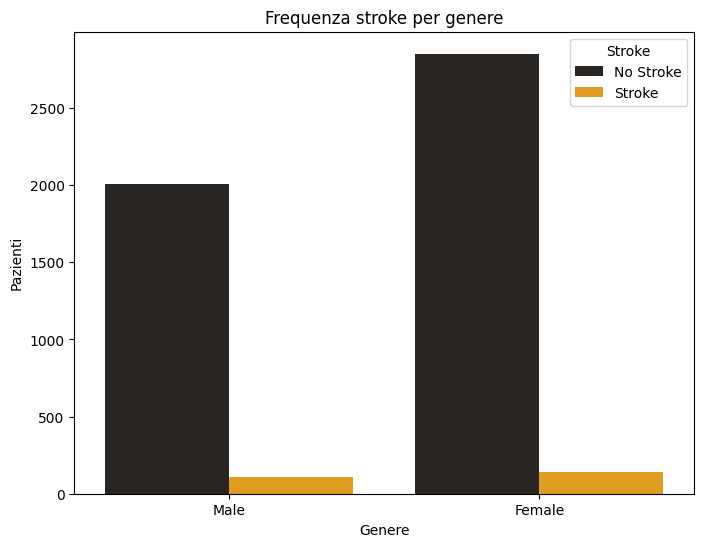

In [7]:
# Crea un grafico a barre della frequenza degli ictus suddivisi per genere
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', hue='stroke', data=ds_stroke, color='orange')
plt.title('Frequenza stroke per genere')
plt.xlabel('Genere')
plt.ylabel('Pazienti')
plt.legend(title='Stroke', labels=['No Stroke', 'Stroke'])
plt.show()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64


<Axes: xlabel='smoking_status', ylabel='Count'>

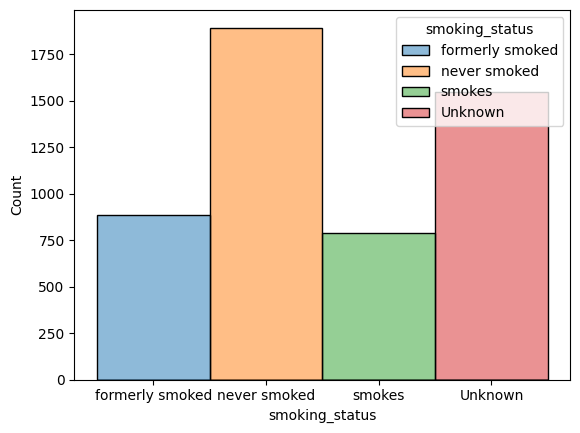

In [8]:

print(ds_stroke['smoking_status'].value_counts())


#Rappresentiamo graficamente quello appena visto:
sns.histplot(data=ds_stroke , hue="smoking_status" , x = 'smoking_status')


La feautre smoking_status può assumere 4 valori. Uno di questi è Unknow, ovvero, informazione non disponibile per quel campione. Visto che il numero di campioni in cui smoking_statu assume come valore Unknow sono molti, 1544 su 5110, bisogna vedere come gestirli.
Nel caso in cui decidessi di eliminare tutti questi campioni perderei un sacco di dati, ma allo stesso tempo splittare questi campioni senza una buona logica, potrebbe non essere efficente e veritiero.
Facendo delle ricerche ho visto che dai dati istat del 2021, il 19,0% della popolazione di 14 anni e più dichiara di essere fumatore, il 24,0% di aver fumato in passato e il 55,7% di non aver mai fumato.

Quindi, vado a mettere tutti i campioni con età inferiore ai 14 anni come never smoked ,il 19% dei campioni con età superiore a 14 anni come smokes, 24% dei campioni come formely smoked e i restanti 56% dei campioni come never smoked.

I campioni con età inferiore a 14 anni sono: 645
smoking_status
never smoked       2477
Unknown             959
formerly smoked     884
smokes              789
Name: count, dtype: int64


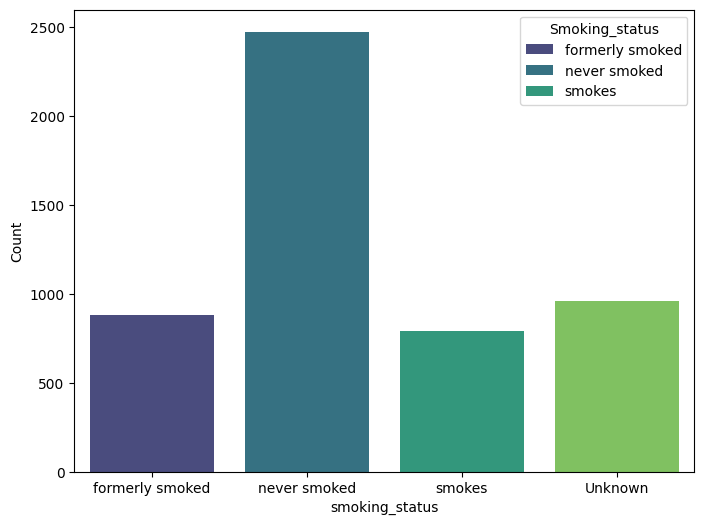

In [9]:
# Filtro i campioni con età inferiore a 14
campioni_meno_di_14_anni = ds_stroke[ds_stroke['age'] < 14]

print(f"I campioni con età inferiore a 14 anni sono: {campioni_meno_di_14_anni.shape[0]}")
#A questo punto tutti metto tutti i campioni con meno di 14 anni che hanno smoking_status ="Unknow" come never smoked
ds_stroke.loc[(ds_stroke['age'] < 14) & (ds_stroke['smoking_status'] == 'Unknown'), 'smoking_status'] = 'never smoked'
print(ds_stroke['smoking_status'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x='smoking_status', hue='smoking_status', data=ds_stroke, palette='viridis')
plt.xlabel('smoking_status')
plt.ylabel('Count')
plt.legend(title='Smoking_status', labels=['formerly smoked', 'never smoked','smokes'])
plt.show()



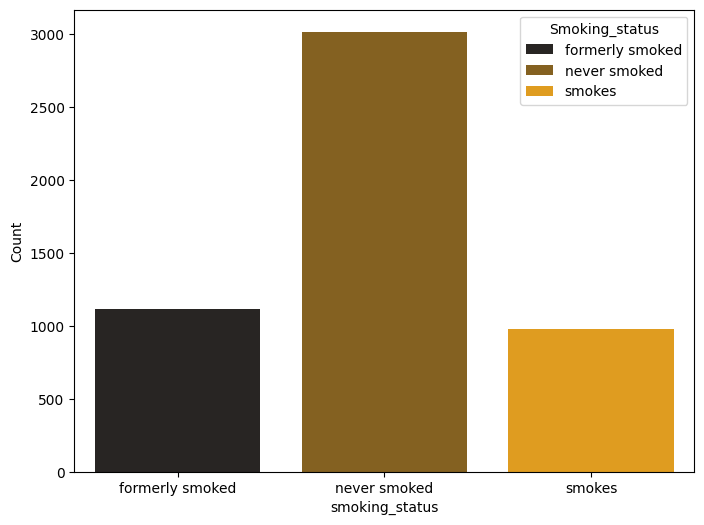

smoking_status
never smoked       3017
formerly smoked    1116
smokes              976
Name: count, dtype: int64


In [10]:
#Ora splitto i restanti valori Unknow con le percentuali sopra dette
def replace(riga):
    if riga["smoking_status"] == "Unknown":
        return np.random.choice(["smokes" ,"formerly smoked" ,"never smoked"] , p = [0.20 ,0.24 ,0.56])
    else:
        return riga["smoking_status"]
    
ds_stroke["smoking_status"] = ds_stroke.apply(replace , axis=1)

plt.figure(figsize=(8, 6))
sns.countplot(x='smoking_status', hue='smoking_status', data=ds_stroke, color='orange')
plt.xlabel('smoking_status')
plt.ylabel('Count')
plt.legend(title='Smoking_status', labels=['formerly smoked', 'never smoked','smokes'])
plt.show()
print(ds_stroke["smoking_status"].value_counts())


Controllo se l'età potrebbe essere un fattore di rischio significativo per lo sviluppo di un ictus.


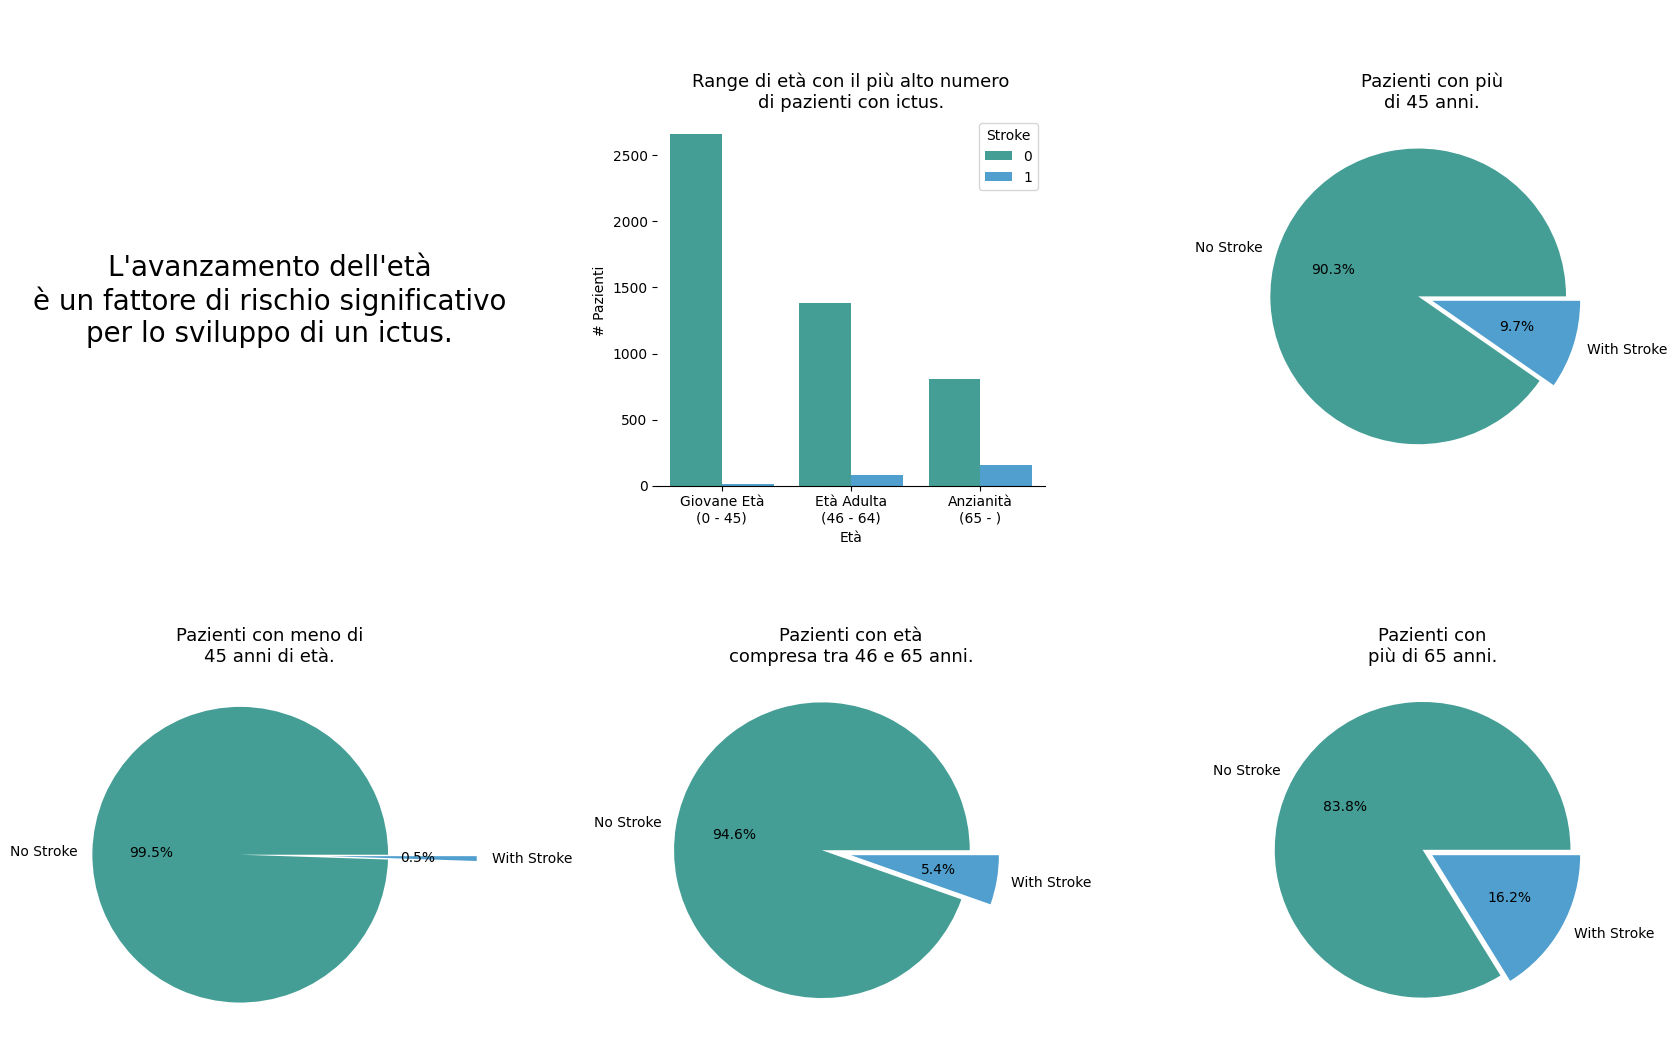

In [11]:
# Categorizzazione dell'età
#preparazione del dataframe che verrà utilizzato per i successivi grafici
data = ds_stroke[['age','bmi','smoking_status','hypertension','heart_disease','avg_glucose_level','stroke']]
ds_age = pd.DataFrame(data)
ds_age['age_range'] = pd.cut(ds_age['age'], bins=[0, 46, 65, np.inf], include_lowest=True,
                             labels=["Giovane Età\n(0 - 45)", "Età Adulta\n(46 - 64)", "Anzianità\n(65 - )"])

ds_age['old_age'] = pd.cut(ds_age['age'], bins=[0, 46, np.inf], include_lowest=True,
                             labels=["Giovane Età", "Età Adulta & Anzianità"])
# Età Adulta & Anzianità.
adul_old = len(ds_age.loc[(ds_age['old_age'] == "Età Adulta & Anzianità") & (ds_age['stroke'] == 0)])
adul_old_stroke = len(ds_age.loc[(ds_age['old_age'] == "Età Adulta & Anzianità") & (ds_age['stroke'] == 1)])
adul_old_total = len(ds_age.loc[(ds_age['old_age'] == "Età Adulta & Anzianità")])
adul_old = round((adul_old / adul_old_total) * 100, 2)
adul_old_stroke = round((adul_old_stroke / adul_old_total) * 100, 2)
patients_adul_old = [adul_old, adul_old_stroke]

# Giovane Età.
youth = len(ds_age.loc[(ds_age['age_range'] == "Giovane Età\n(0 - 45)") & (ds_age['stroke'] == 0)])
youth_stroke = len(ds_age.loc[(ds_age['age_range'] == "Giovane Età\n(0 - 45)") & (ds_age['stroke'] == 1)])
youth_total = len(ds_age.loc[(ds_age['age_range'] == "Giovane Età\n(0 - 45)")])
youth = round((youth / youth_total) * 100, 2)
youth_stroke = round((youth_stroke / youth_total) * 100, 2)
patients_youth = [youth, youth_stroke]

# Età adulta.
adul = len(ds_age.loc[(ds_age['age_range'] == "Età Adulta\n(46 - 64)") & (ds_age['stroke'] == 0)])
adul_stroke = len(ds_age.loc[(ds_age['age_range'] == "Età Adulta\n(46 - 64)") & (ds_age['stroke'] == 1)])
adul_total = len(ds_age.loc[(ds_age['age_range'] == "Età Adulta\n(46 - 64)")])
adul = round((adul / adul_total) * 100, 2)
adul_stroke = round((adul_stroke / adul_total) * 100, 2)
patients_adul = [adul, adul_stroke]

# Anzianità.
old = len(ds_age.loc[(ds_age['age_range'] == "Anzianità\n(65 - )") & (ds_age['stroke'] == 0)])
old_stroke = len(ds_age.loc[(ds_age['age_range'] == "Anzianità\n(65 - )") & (ds_age['stroke'] == 1)])
old_total = len(ds_age.loc[(ds_age['age_range'] == "Anzianità\n(65 - )")])
old = round((old / old_total) * 100, 2)
old_stroke = round((old_stroke / old_total) * 100, 2)
patients_old = [old, old_stroke]

# Plot
fig = plt.figure(figsize=(20,12))
gs = fig.add_gridspec(2,3)
gs.update(wspace=0.5, hspace=0.5)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,"L'avanzamento dell'età\nè un fattore di rischio significativo\nper lo sviluppo di un ictus.",
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot Age Range.
ds_melted = pd.melt(ds_age, id_vars=['age_range'], value_vars=['stroke'])
ax1 = fig.add_subplot(gs[0,1])
ax1 = sns.countplot(x='age_range', hue='value', data=ds_melted, palette=palette)
ax1.set_title(f"\n\n\nRange di età con il più alto numero\ndi pazienti con ictus.", fontsize=13)
ax1.legend(title='Stroke')
ax1.spines[['top', 'right', 'left']].set_visible(False)
ax1.set_xlabel('Età')
ax1.set_ylabel('# Pazienti')

# Plot Età adulta.
ax2 = fig.add_subplot(gs[0, 2])
ax2 = plt.pie(patients_adul_old, labels = ['No Stroke', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors = ['#449E95', '#509FCF'])
plt.title("Pazienti con più\ndi 45 anni.", fontsize=13)

# Plot Giovani.
ax2 = fig.add_subplot(gs[1, 0])
ax2 = plt.pie(patients_youth, labels = ['No Stroke', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0.4], colors = ['#449E95', '#509FCF'])
plt.title("Pazienti con meno di\n45 anni di età.", fontsize=13)

# Plot Età adulta.
ax2 = fig.add_subplot(gs[1, 1])
ax2 = plt.pie(patients_adul, labels = ['No Stroke', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0], colors = ['#449E95', '#509FCF'])
plt.title("Pazienti con età\ncompresa tra 46 e 65 anni.", fontsize=13)

# Plot Anziani.
ax2 = fig.add_subplot(gs[1, 2])
ax2 = plt.pie(patients_old, labels = ['No Stroke', 'With Stroke'], autopct='%1.1f%%', explode=[0.075, 0], colors = ['#449E95', '#509FCF'])
plt.title("Pazienti con\npiù di 65 anni.", fontsize=13)

plt.show()

Come possiamo vedere dai grafici, esiste una tendenza positiva dei pazienti che hanno avuto un ictus in base all'età. Notiamo come all'aumentare dell'età, aumenti la possibilità di contrarre un ictus.

Controllo se pazienti con età avanzata e con un valore di BMI alto hasvmo maggior rischio.


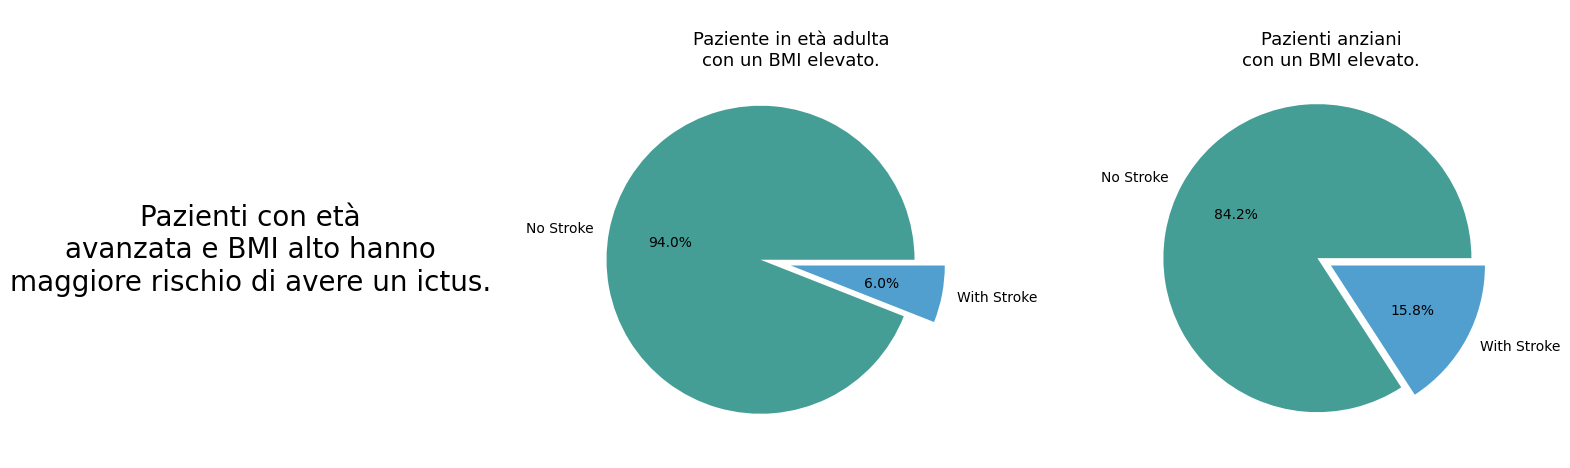

In [12]:
# Categorizzazione dei Pazienti con un elevato IBM
ds_age['high BMI'] = pd.cut(ds_age['bmi'], bins=[0, 18.5, 24.9, np.inf], include_lowest=True,
                            labels=["Below Average", "Normal", "High BMI"])

# Età Adulta.
adul_h_AgeBMI = len(ds_age.loc[(ds_age['age_range'] == 'Età Adulta\n(46 - 64)') & (ds_age['high BMI'] == 'High BMI') & (ds_age['stroke'] == 0)])
adul_h_AgeBMI_stroke = len(ds_age.loc[(ds_age['age_range'] == 'Età Adulta\n(46 - 64)') & (ds_age['high BMI'] == 'High BMI') & (ds_age['stroke'] == 1)])
adul_h_AgeBMI_total = len(ds_age.loc[(ds_age['age_range'] == 'Età Adulta\n(46 - 64)') & (ds_age['high BMI'] == 'High BMI')])
adul_h_AgeBMI = round((adul_h_AgeBMI / adul_h_AgeBMI_total) * 100, 2)
adul_h_AgeBMI_stroke = round((adul_h_AgeBMI_stroke / adul_h_AgeBMI_total) * 100, 2)
pacients_adul_h_AgeBMI_total = [adul_h_AgeBMI, adul_h_AgeBMI_stroke]

# Anzianità.
old_h_AgeBMI = len(ds_age.loc[(ds_age['age_range'] == 'Anzianità\n(65 - )') & (ds_age['high BMI'] == 'High BMI') & (ds_age['stroke'] == 0)])
old_h_AgeBMI_stroke = len(ds_age.loc[(ds_age['age_range'] == 'Anzianità\n(65 - )') & (ds_age['high BMI'] == 'High BMI') & (ds_age['stroke'] == 1)])
old_h_AgeBMI_total = len(ds_age.loc[(ds_age['age_range'] == 'Anzianità\n(65 - )') & (ds_age['high BMI'] == 'High BMI')])
old_h_AgeBMI = round((old_h_AgeBMI / old_h_AgeBMI_total) * 100, 2)
old_h_AgeBMI_stroke = round((old_h_AgeBMI_stroke / old_h_AgeBMI_total) * 100, 2)
pacients_old_h_AgeBMI = [old_h_AgeBMI, old_h_AgeBMI_stroke]

# Plot
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Pazienti con età\navanzata e BMI alto hanno\nmaggiore rischio di avere un ictus.\n',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot Età Adulta.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(pacients_adul_h_AgeBMI_total, labels = ['No Stroke', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nPaziente in età adulta\ncon un BMI elevato.", fontsize=13)

# Plot Old.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(pacients_old_h_AgeBMI, labels = ['No Stroke', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nPazienti anziani\ncon un BMI elevato.", fontsize=13)

plt.show()

Controllo frequenza stroke in pazienti fumatori, non fumatori ed ex-fumatori

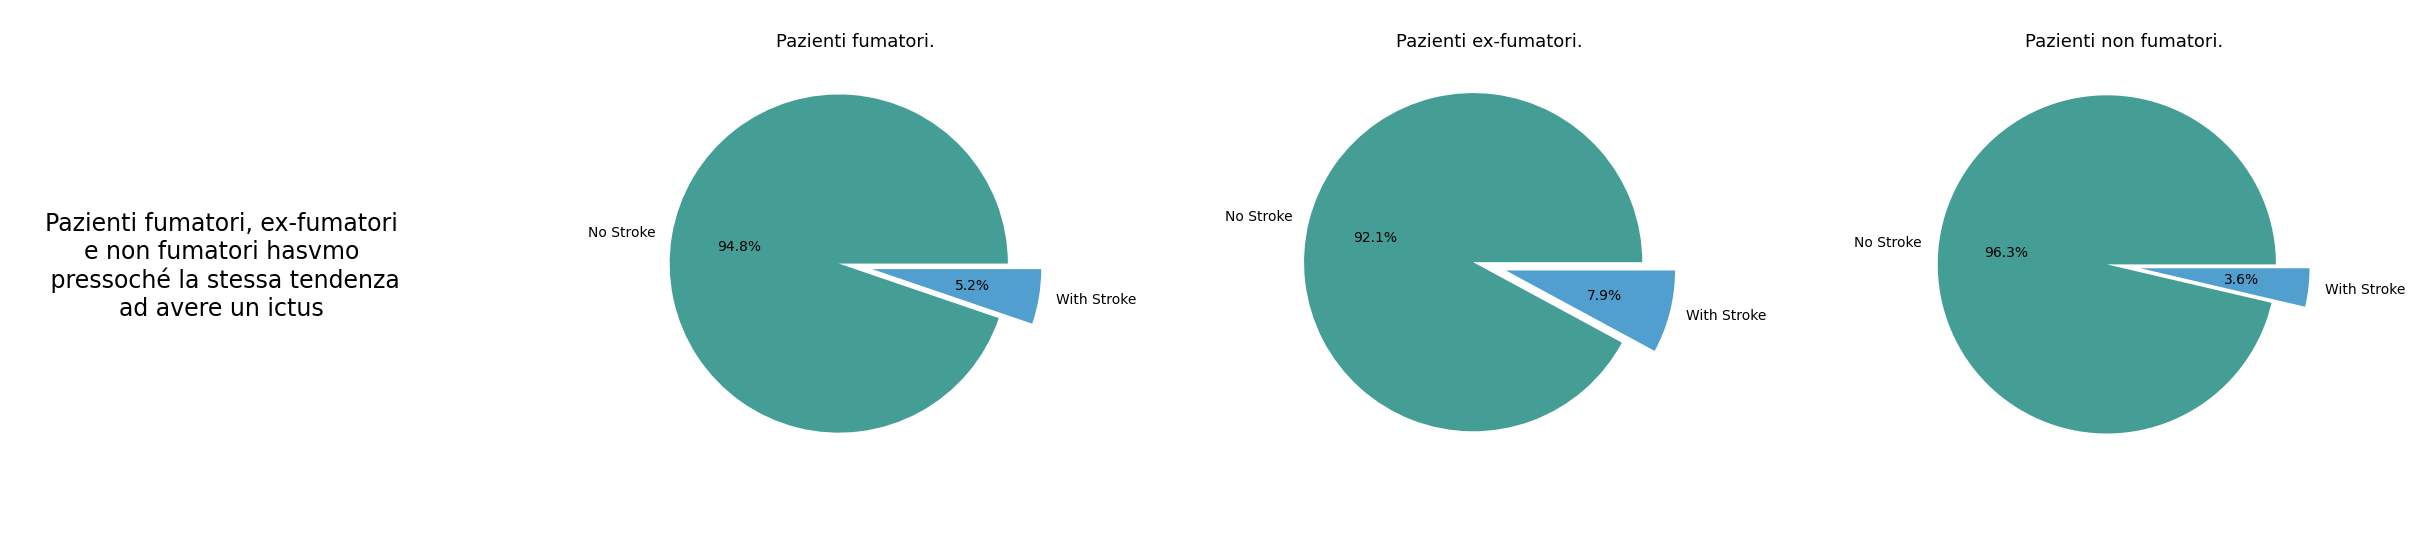

In [13]:
# Categorizzazione di pazienti fumatori con bmi elevato

# Formerly Smokes.
f_formerly_smokes = len(ds_age.loc[(ds_age['smoking_status'] == 'formerly smoked')  & (ds_age['stroke'] == 0)])
f_formerly_smokes_stroke = len(ds_age.loc[(ds_age['smoking_status'] == 'formerly smoked') & (ds_age['stroke'] == 1)])
f_formerly_smokes_stroke_total = len(ds_age.loc[(ds_age['smoking_status'] == 'formerly smoked') ])
f_formerly_smokes = round((f_formerly_smokes / f_formerly_smokes_stroke_total) * 100, 2)
f_formerly_smokes_stroke = round((f_formerly_smokes_stroke / f_formerly_smokes_stroke_total) * 100, 2)
f_formerly_smokes_highBMI = [f_formerly_smokes, f_formerly_smokes_stroke]

# Smokes.
f_smokes = len(ds_age.loc[(ds_age['smoking_status'] == 'smokes')  & (ds_age['stroke'] == 0)])
f_smokes_stroke = len(ds_age.loc[(ds_age['smoking_status'] == 'smokes') & (ds_age['stroke'] == 1)])
f_smokes_total = len(ds_age.loc[(ds_age['smoking_status'] == 'smokes')  ])
f_smokes = round((f_smokes / f_smokes_total) * 100, 2)
f_smokes_stroke = round((f_smokes_stroke / f_smokes_total) * 100, 2)
f_smoke_highBMI = [f_smokes, f_smokes_stroke]

# No Smokes.
no_smokes = len(ds_age.loc[(ds_age['smoking_status'] == 'never smoked')&  (ds_age['stroke'] == 0)])
no_smokes_stroke = len(ds_age.loc[(ds_age['smoking_status'] == 'never smoked')& (ds_age['stroke'] == 1)])
no_smokes_total = len(ds_age.loc[(ds_age['smoking_status'] == 'never smoked') ])
no_smoke = round((no_smokes / no_smokes_total) * 100, 2)
no_smokes_stroke = round((no_smokes_stroke / no_smokes_total) * 100, 2)
no_smoke_highBMI = [no_smoke, no_smokes_stroke]

# Plots
fig = plt.figure(figsize=(30,20))
gs = fig.add_gridspec(2,4)
gs.update(wspace=0.5, hspace=1)

# Plot Title Smokes
ax3 = fig.add_subplot(gs[0,0])
ax3.text(0.5,0.5,'Pazienti fumatori, ex-fumatori\ne non fumatori hasvmo\n pressoché la stessa tendenza\nad avere un ictus',
         fontsize=17, horizontalalignment='center', verticalalignment='center')
ax3.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax3.tick_params(left=False, bottom=False)
ax3.set_xticklabels([])
ax3.set_yticklabels([])

# Plot Smokes.
ax3 = fig.add_subplot(gs[0,1])
ax3 = plt.pie(f_smoke_highBMI, labels = ['No Stroke', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("Pazienti fumatori.", fontsize=13)

# Plot formerly smoked.
ax4 = fig.add_subplot(gs[0,2])
ax4 = plt.pie(f_formerly_smokes_highBMI, labels = ['No Stroke', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("Pazienti ex-fumatori.", fontsize=13)

# Plot No Smokes.
ax5 = fig.add_subplot(gs[0,3])
ax5 = plt.pie(no_smoke_highBMI, labels = ['No Stroke', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("Pazienti non fumatori.", fontsize=13)

plt.show()

Controllo se pazienti con ipertensione e malattie cardiache hanno maggiori probabilità di avere un ictus rispetto a quelli senza queste condizioni.


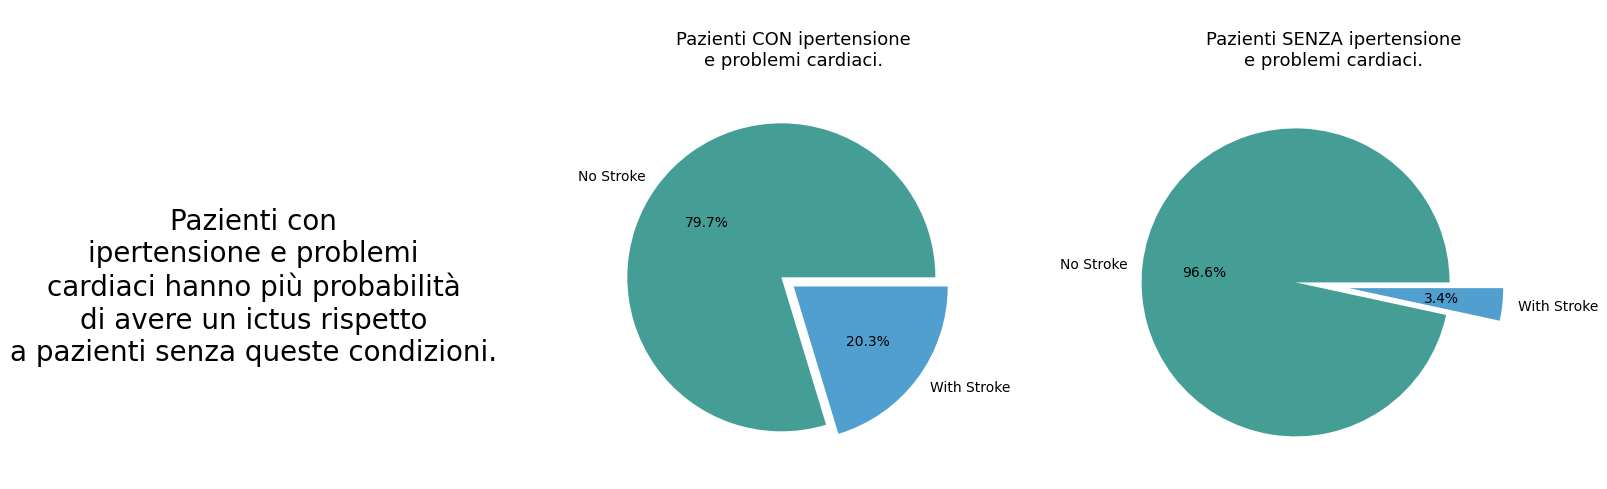

In [14]:
# Con patologie.
with_hh = len(ds_age.loc[(ds_age['hypertension'] == 1) & (ds_age['heart_disease'] == 1) & (ds_age['stroke'] == 0)])
with_hh_stroke = len(ds_age.loc[(ds_age['hypertension'] == 1) & (ds_age['heart_disease'] == 1) & (ds_age['stroke'] == 1)])
with_hh_total = len(ds_age.loc[(ds_age['hypertension'] == 1) & (ds_age['heart_disease'] == 1)])
with_hh = round((with_hh / with_hh_total) * 100, 2)
with_hh_stroke = round((with_hh_stroke / with_hh_total) * 100, 2)
patients_with_hh = [with_hh, with_hh_stroke]

# Semza patologie.
without_hh = len(ds_age.loc[(ds_age['hypertension'] == 0) & (ds_age['heart_disease'] == 0) & (ds_age['stroke'] == 0)])
without_hh_stroke = len(ds_age.loc[(ds_age['hypertension'] == 0) & (ds_age['heart_disease'] == 0) & (ds_age['stroke'] == 1)])
without_hh_total = len(ds_age.loc[(ds_age['hypertension'] == 0) & (ds_age['heart_disease'] == 0)])
without_hh = round((without_hh / without_hh_total) * 100, 2)
without_hh_stroke = round((without_hh_stroke / without_hh_total) * 100, 2)
patients_without_hh = [without_hh, without_hh_stroke]

# Plot
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Pazienti con\nipertensione e problemi\ncardiaci hanno più probabilità\ndi avere un ictus rispetto\na pazienti senza queste condizioni.',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot With.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(patients_with_hh, labels = ['No Stroke', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nPazienti CON ipertensione\ne problemi cardiaci.\n", fontsize=13)

# Plot Without.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(patients_without_hh, labels = ['No Stroke', 'With Stroke'], autopct='%1.1f%%', explode=[0.25, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("Pazienti SENZA ipertensione\ne problemi cardiaci.\n", fontsize=13)

plt.show()

Controllo se pazienti con livelli elevati di glucosio nel sangue (Diabete) hasvmo un rischio maggiore di avere un ictus rispetto a quelli con livelli normali di glucosio.

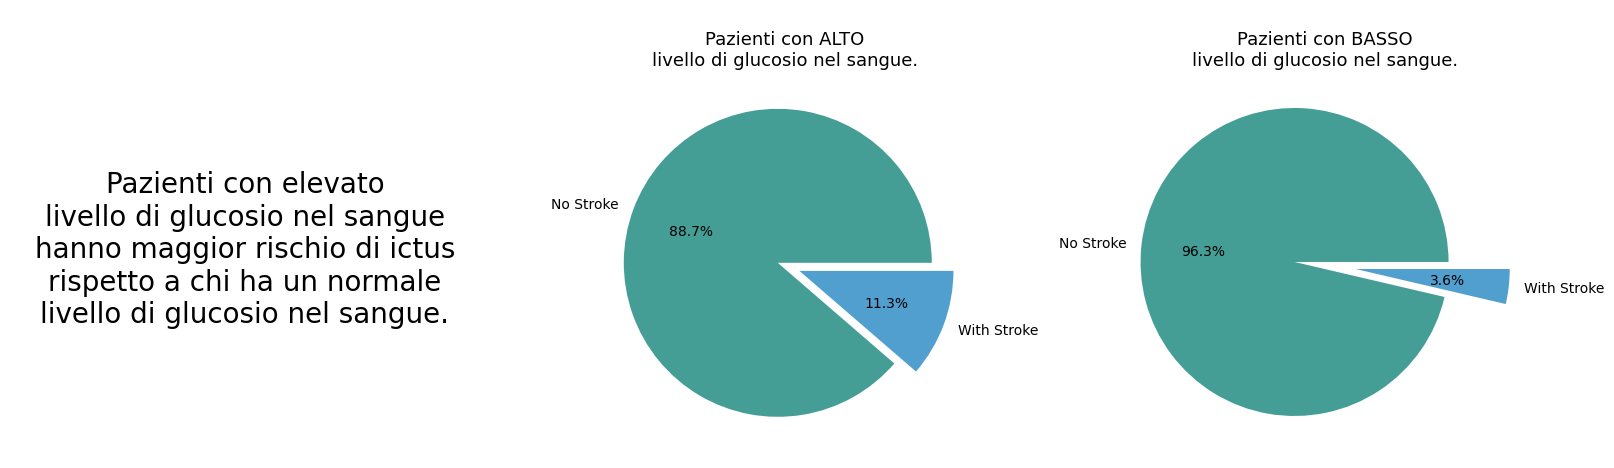

In [15]:
ds_age['avg_gluc_lvl_range'] = pd.cut(ds_age['avg_glucose_level'], bins=[0, 70, 140, np.inf], include_lowest=True,
                                          labels=["Low Level", "Normal Level", "High Level"])

# High. 
high = len(ds_age.loc[(ds_age['avg_gluc_lvl_range'] == 'High Level') & (ds_age['stroke'] == 0)])
high_stroke =  len(ds_age.loc[(ds_age['avg_gluc_lvl_range'] == 'High Level') & (ds_age['stroke'] == 1)])
high_total = len(ds_age.loc[(ds_age['avg_gluc_lvl_range'] == 'High Level')])
high = round((high / high_total) * 100, 2)
high_stroke = round((high_stroke / high_total) * 100, 2)
patients_high = [high, high_stroke]

# Normal.
normal = len(ds_age.loc[(ds_age['avg_gluc_lvl_range'] == 'Normal Level') & (ds_age['stroke'] == 0)])
normal_stroke = len(ds_age.loc[(ds_age['avg_gluc_lvl_range'] == 'Normal Level') & (ds_age['stroke'] == 1)])
normal_total = len(ds_age.loc[(ds_age['avg_gluc_lvl_range'] == 'Normal Level')])
normal = round((normal / normal_total) * 100, 2)
normal_stroke = round((normal_stroke / normal_total) * 100, 2)
patients_normal = [normal, normal_stroke]

# Plot.
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title.
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Pazienti con elevato\nlivello di glucosio nel sangue\nhanno maggior rischio di ictus\nrispetto a chi ha un normale\nlivello di glucosio nel sangue.\n',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot High.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(patients_high, labels = ['No Stroke', 'With Stroke'], autopct='%1.1f%%', explode=[0.05, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("\nPazienti con ALTO\nlivello di glucosio nel sangue.", fontsize=13)

# Plot Low.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(patients_normal, labels = ['No Stroke', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0.2], colors = ['#449E95', '#509FCF'])
plt.title("\nPazienti con BASSO\nlivello di glucosio nel sangue.", fontsize=13)

plt.show()

CALCOLO CORRELATION MATRIX

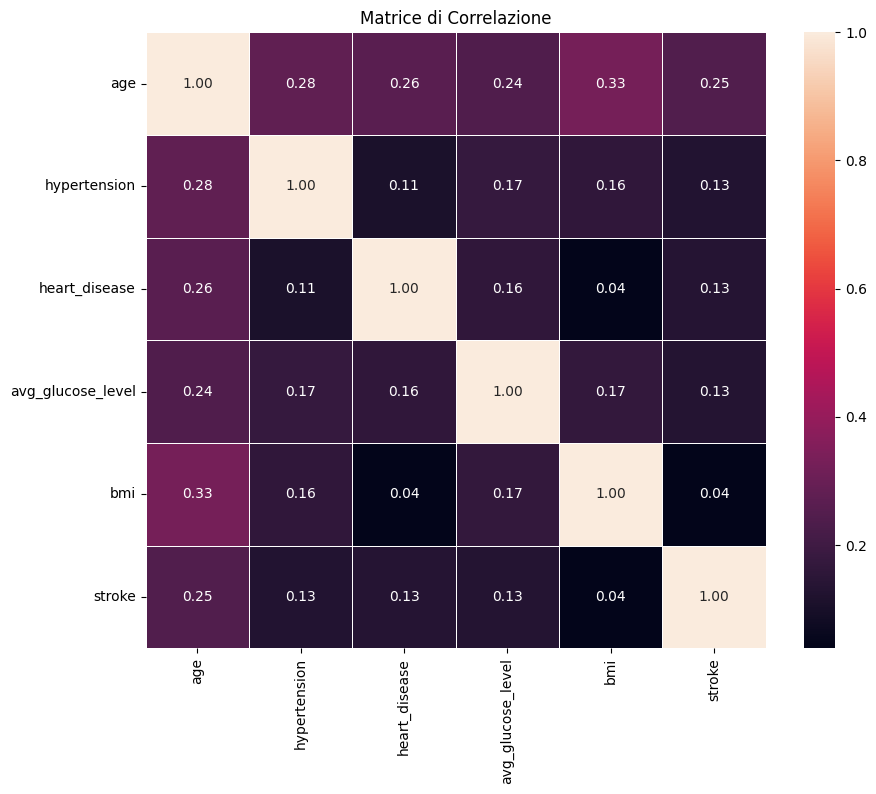

In [16]:
corr_matrix = ds_stroke.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=.5)
plt.title('Matrice di Correlazione')
plt.show()

Dalla Correlation Matrix possiamo vedere come non ci siano feature con un'elevata correlazione diretta o inversa. Questo controllo è stato fatto perché nel caso avessimo avuto due feature fortemente correlate, avremmo potuto rimuoverne una perché apporterebbero le stesse informazioni. 

Nonostante la correlation matrix, non possiamo verificare la presenza di multicollinearità tra più di due feature, per farlo, dobbiamo calcolare il VIF (fattore di inflazione della varianza).

Dummizzazione di feature categoriche

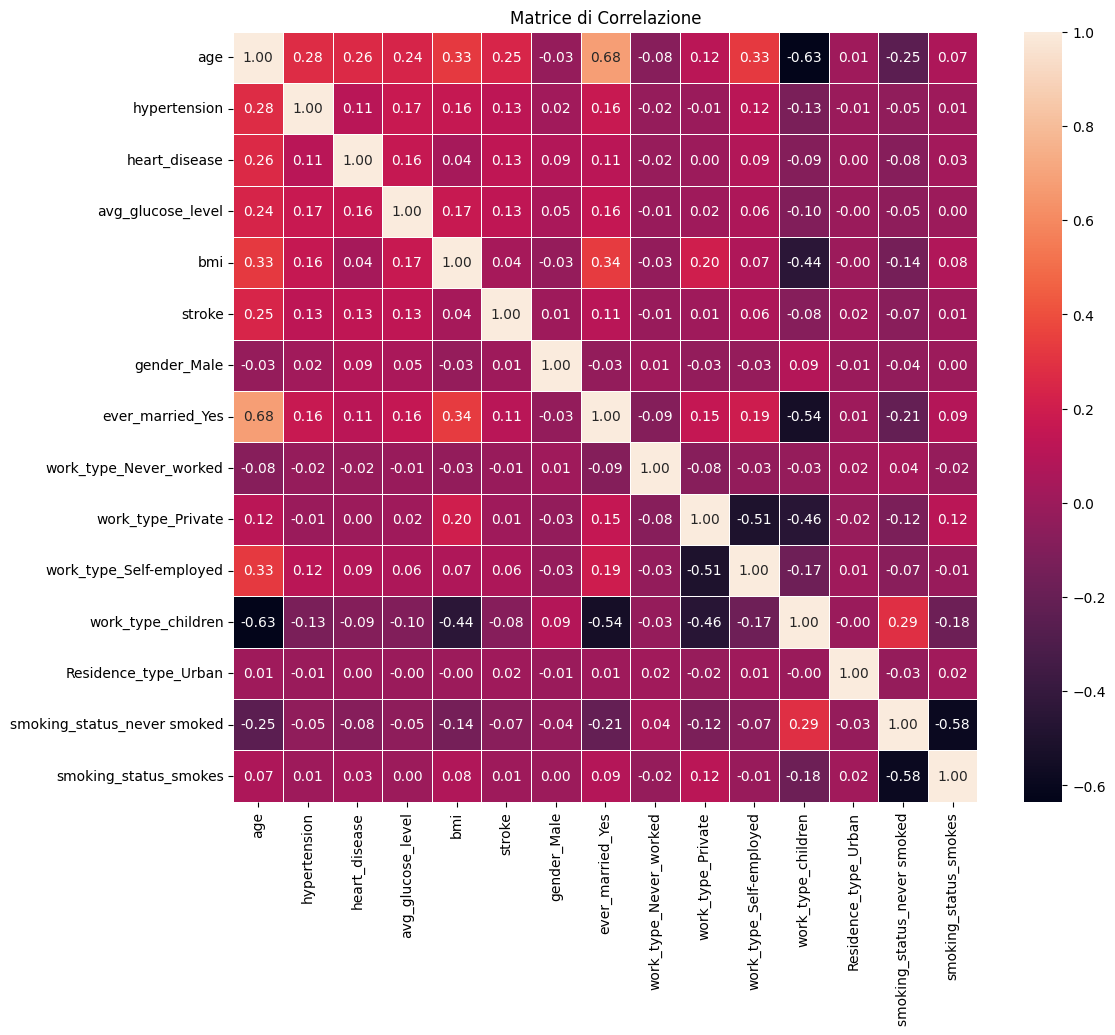

0
<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          5109 non-null   float64
 1   hypertension                 5109 non-null   int64  
 2   heart_disease                5109 non-null   int64  
 3   avg_glucose_level            5109 non-null   float64
 4   bmi                          5109 non-null   float64
 5   stroke                       5109 non-null   int64  
 6   gender_Male                  5109 non-null   bool   
 7   ever_married_Yes             5109 non-null   bool   
 8   work_type_Never_worked       5109 non-null   bool   
 9   work_type_Private            5109 non-null   bool   
 10  work_type_Self-employed      5109 non-null   bool   
 11  work_type_children           5109 non-null   bool   
 12  Residence_type_Urban         5109 non-null   bool   
 13  smoking_status_never 

In [17]:
columns_to_encode = ["gender" ,"ever_married","work_type" ,"Residence_type","smoking_status"]
ds_stroke = pd.get_dummies(ds_stroke , columns=columns_to_encode, drop_first=True)
corr_matrix = ds_stroke.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=.5)
plt.title('Matrice di Correlazione')
plt.show()

print(ds_stroke.duplicated().sum())
print(ds_stroke.info())


Check numerical features


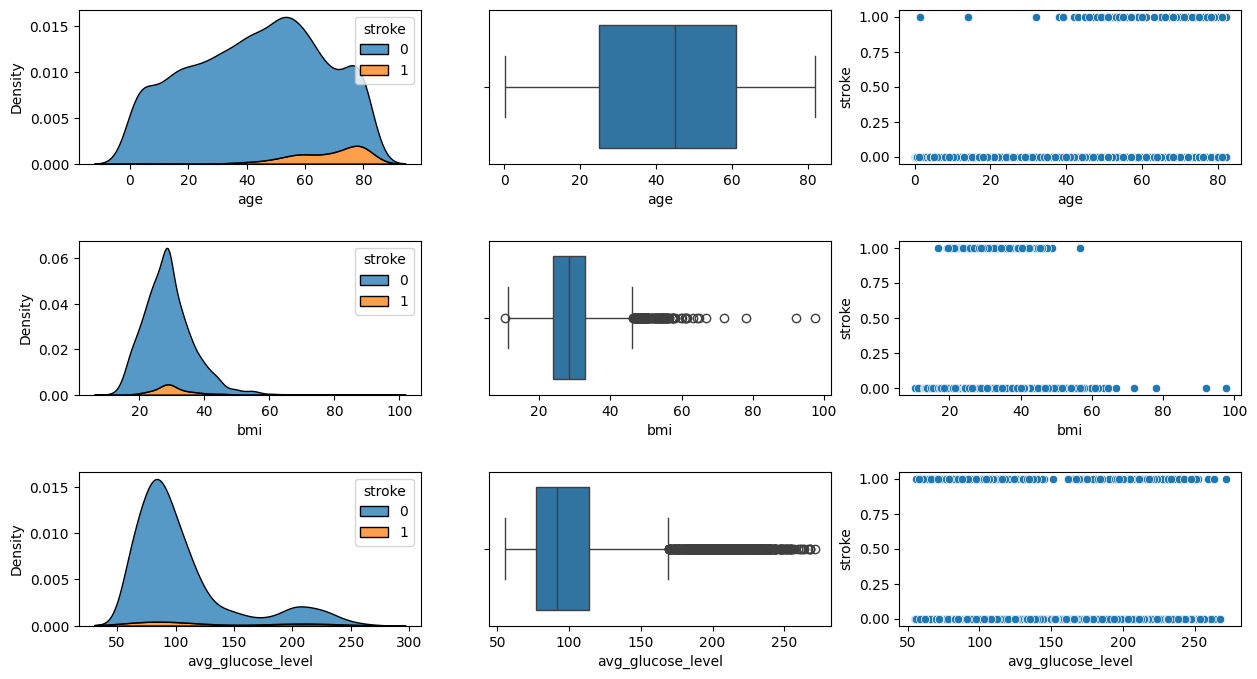

In [18]:
numeric_columns = ['age', 'bmi', 'avg_glucose_level']

i = 0
fig, ax = plt.subplots(3, 3, figsize=(15, 8))
plt.subplots_adjust(hspace = 0.5)
for num_col in numeric_columns :
    sns.kdeplot(x=num_col, hue='stroke', data=ds_stroke, multiple='stack', ax=ax[i,0])
    sns.boxplot(x=num_col, data=ds_stroke, ax=ax[i, 1])
    sns.scatterplot(x=num_col, y='stroke', data=ds_stroke, ax=ax[i, 2])
    i+=1
plt.show()

Gli outlier rilevati devono essere considerati in modo da non influenzare il modello di classificazione. Si decide di utilizzare il trasformatore Robust Scaler, in modo che il modello non sia influenzato dagli outlier.

Studio della feature stroke per vedere se dataset sbilanciato o meno.

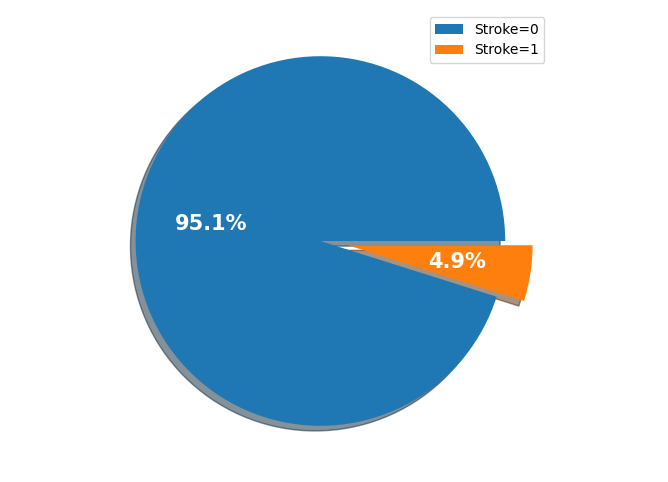

In [19]:
x = ds_stroke['stroke'].value_counts()

explode = [0, 0.15]
labels = ['Stroke=0', 'Stroke=1']
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

plt.pie(x, explode=explode, shadow=True, autopct='%1.1f%%', labels=labels, textprops=dict(color="w", weight='bold', size=15))
plt.legend()
plt.show()


Possiamo vedere come il nostro dataset sia estremamente sbilanciato. Questo potrebbe portarmi molti problemi perché avendo una classe estremamente sotto-rappresentata potrei avere un accuracy alta dovuta dal fatto che la classa sotto rappresentata non viene mai predetta. Senza un bilanciamento, potrei avere  delle scarse prestazioni con F1-score relativamente basso.

Dopo aver provato anche varie tecniche di oversampling come SMOTE e SMOTEENN, le prestazioni non sono comunque migliorate, anzi c'era molto overfitting tra training e deploy/test. A quel punto ho deciso di vedere quali siano le feature che potrebbero influenzare maggiormente la classificazione e provare a tenere in considerazioni solo quelle per vedere se diminuendo la complessità si avesse un miglioramento.

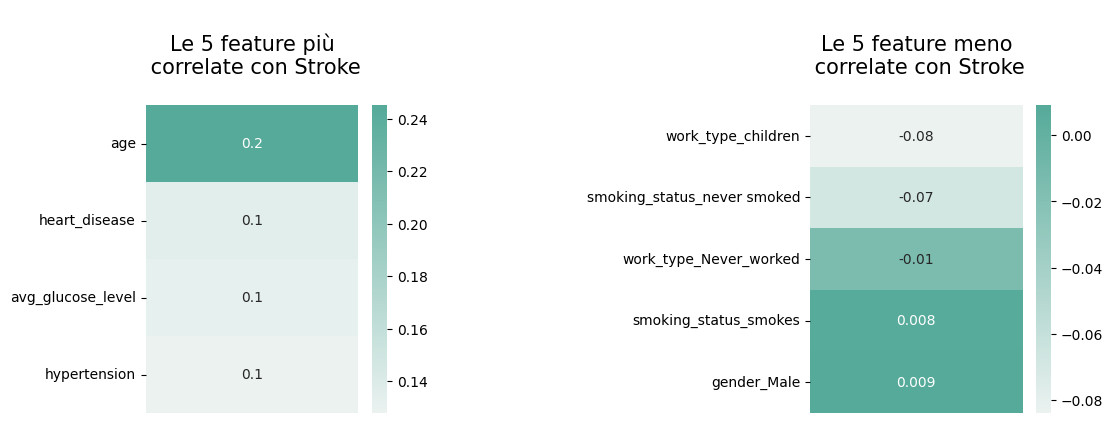

In [20]:

corr_higher = pd.DataFrame(corr_matrix['stroke'].sort_values(ascending=False)).head()
corr_higher = corr_higher.drop('stroke', axis=0)

corr_less = pd.DataFrame(corr_matrix['stroke'].sort_values()).head()

corr_ls = [corr_higher, corr_less]
description = [str(f'\nLe 5 feature più\n correlate con Stroke\n'), str(f'Le 5 feature meno\n correlate con Stroke\n')]
fig = plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1,2)
gs.update(wspace=1.5, hspace=0.35)

for i, j in enumerate(corr_ls):
    ax = plt.subplot(gs[i])
    sns.heatmap(corr_ls[i], annot=True, fmt='.1g', cmap=palette_matrix, cbar=True)
    ax.set_title(description[i], fontsize=15)
    ax.set_xlabel('')
    ax.set_xticklabels([])
    ax.tick_params(bottom=False)
plt.show()

FINE EDA, DIVISIONE DEL DATASET

Nonostante il nostro dataset sia composto da ben 5110, non possiamo comunque parlare di un dataset di grande dimensione. Questa è un osservazione che ho fatto per capire cosa sia meglio utilizzare tra set a validazione fisso e cross validation. In questo caso ho deciso di utilizzare la cross validation, adatto a quei dataset di medie dimensioni. Procedo con il splittare il dataset come segue:
70% training/validation, 10% deployment e 20% test

P.S Nonostante le numerose prove, il forte sbilanciamento del dataset mi portava molti problemi in fase di addestramento. Infatti andando a visualizzare alcune metriche tra cui l'accuracy si aveva un "buon valore" perchè avevo valori F1_Score molto bassi (all'incirca 0.48), ma la cosa più interessante è che avevo un'accuracy del 95% e plottando la confusion matrix si poteva vedere come la classe sotto rappresentata nonveniva totalmente classificata con valori di TP = 0. Per questo ho deciso di utilizzare la  SMOTE (Synthetic Minority Over-sampling Technique) che consiste nell'aggiungere più istanze della classe minoritaria nel set di dati, in modo che il numero di campioni per ciascuna classe sia più bilanciato.

In [21]:

ds_stroke = ds_stroke.sample(frac=1).reset_index(drop=True)

X = ds_stroke.drop(["stroke"] , axis=1)
t = ds_stroke["stroke"]

X = pd.DataFrame(X, columns = ['age', 'hypertension', 'avg_glucose_level', 'gender_Male', 
                               'work_type_Private','work_type_children','Residence_type_Urban', 'smoking_status_never smoked','smoking_status_smokes','heart_disease'])

cols_final = X.columns.values
training_split = 0.7
development_split = 0.8

tr_size = int(X.shape[0]*training_split)
dep_size = int(X.shape[0]*development_split)

X_tr = X[0:tr_size]
t_tr = t[0:tr_size]


X_dep = X[tr_size:dep_size]
t_dep = t[tr_size:dep_size]
X_dep.reset_index(drop=True , inplace=True)
t_dep.reset_index(drop=True , inplace=True)


X_te = X[dep_size:]
t_te = t[dep_size:]
X_te.reset_index(drop=True , inplace=True)
t_te.reset_index(drop=True , inplace=True)
print(X_te.shape,t_te.shape)


(1022, 10) (1022,)


Nonostante i valori assunti dalle feature non si discostino molto l'uno dall'altro sto pensando di normalizzare comunque i vari dataset perchè potrebbe essere più efficente nel caso della stima deglim iperparametri migliori per alcuni modelli 

In [22]:
#Normalizzazione del training set:
temp_tr = X_tr[[ 'gender_Male','work_type_children', 'work_type_Private','Residence_type_Urban', 'smoking_status_never smoked','smoking_status_smokes']]
X_tr = X_tr.drop(['gender_Male','work_type_children', 'work_type_Private','Residence_type_Urban', 'smoking_status_never smoked','smoking_status_smokes'], axis=1)

scaler = RobustScaler()
X_tr_norm = scaler.fit_transform(X_tr)
X_tr_norm = pd.DataFrame(X_tr_norm , columns=['age' ,'hypertension','avg_glucose_level','heart_disease' ])

X_tr_final = pd.concat([ X_tr_norm.reset_index(drop=True) , temp_tr.reset_index(drop=True)] , axis=1 )

print(X_tr_final.shape)

(3576, 10)


In [23]:
#Normalizzazione deployment set:
temp_dep = X_dep[['gender_Male','work_type_children', 'work_type_Private','Residence_type_Urban', 'smoking_status_never smoked','smoking_status_smokes']]
X_dep = X_dep.drop(['gender_Male','work_type_children', 'work_type_Private','Residence_type_Urban', 'smoking_status_never smoked','smoking_status_smokes'], axis=1)

X_dep_norm = scaler.transform(X_dep)
X_dep_norm = pd.DataFrame(X_dep_norm , columns=['age' ,'hypertension','avg_glucose_level','heart_disease' ])
X_dep_final = pd.concat([ X_dep_norm.reset_index(drop=True) , temp_dep.reset_index(drop=True)] , axis=1 )



In [24]:
#Normalizzazione test set:
temp_te = X_te[['gender_Male','work_type_children', 'work_type_Private','Residence_type_Urban', 'smoking_status_never smoked','smoking_status_smokes']]
X_te = X_te.drop(['gender_Male','work_type_children', 'work_type_Private','Residence_type_Urban', 'smoking_status_never smoked','smoking_status_smokes'], axis=1)

X_tes_norm = scaler.transform(X_te)
X_tes_norm = pd.DataFrame(X_tes_norm , columns=['age' ,'hypertension','avg_glucose_level','heart_disease' ])
X_tes_final = pd.concat([ X_tes_norm.reset_index(drop=True) , temp_te.reset_index(drop=True)] , axis=1 )


MODEL SELECTION CON LOGISTIC REGRESSION

In [30]:
#Addestramento su training set e valutazione prestazione su deployment set

parametri = {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
              'C': [0.001 , 0.003 ,0.01 , 0.03 , 0.1 , 0.3 , 1 , 3 , 10 , 30 , 100 , 300 , 1000], 'penalty':['l1','l2'], 'class_weight' : [{1: 0.9, 0: 0.1}]}
logistic_model = LogisticRegression()

# Creo un oggetto GridSearchCV
grid_search_logistic = GridSearchCV(estimator=logistic_model, param_grid=parametri, scoring='f1_macro', cv=5, verbose=2)

# Eseguo la ricerca degli iperparametri
grid_search_logistic.fit(X_tr_final, t_tr)

# Best params e best score
best_params_logistic = grid_search_logistic.best_params_
best_score_logistic = grid_search_logistic.best_score_

# Il modello migliore è già addestrato con i migliori iperparametri
best_model_logistic = grid_search_logistic.best_estimator_
print("Miglior parametri: ",best_params_logistic)
print("Best score: ",best_score_logistic)

t_pred_dep_logistic = best_model_logistic.predict(X_dep_final)
# Calcolo l'F1-score sul set di deployment
f1_score_dep_logistic = f1_score(t_dep, t_pred_dep_logistic, average='macro')
print("F1-score sul deployment set:", f1_score_dep_logistic)

X_deployment_test_combined = pd.concat([X_tr_final, X_dep_final], axis=0, ignore_index=True)
t_dep_tr_combined = pd.concat([t_tr,t_dep], axis=0, ignore_index=True)
#Ora addestramento su deployment set + training set e valutazione prestazione su test set
best_model_logistic.fit(X_deployment_test_combined,t_dep_tr_combined)
t_pred_test_logistic = best_model_logistic.predict(X_tes_final)

# Calcolo l'F1-score sul set di test
f1_score_tes_logistic = f1_score(t_te, t_pred_test_logistic, average='macro')
print("F1-score su test set:", f1_score_tes_logistic)



Fitting 5 folds for each of 130 candidates, totalling 650 fits
[CV] END C=0.001, class_weight={1: 0.9, 0: 0.1}, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight={1: 0.9, 0: 0.1}, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight={1: 0.9, 0: 0.1}, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight={1: 0.9, 0: 0.1}, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight={1: 0.9, 0: 0.1}, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight={1: 0.9, 0: 0.1}, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight={1: 0.9, 0: 0.1}, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight={1: 0.9, 0: 0.1}, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight={1: 0.9, 0: 0.1}, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight={1: 0.9, 0: 0.1}, penalty=l1, solver=libline

FACCIO CONFUSION MATRIX

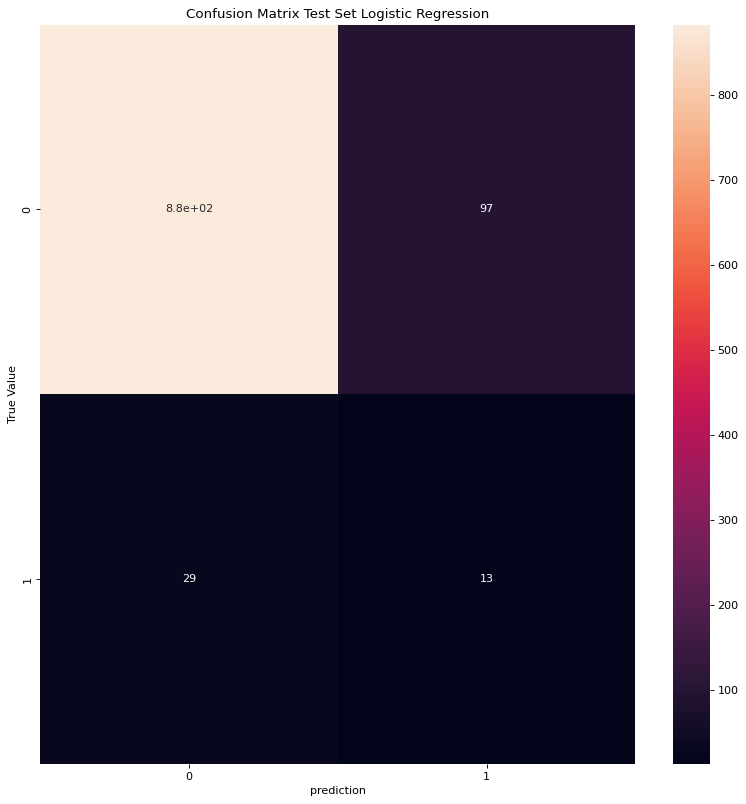

In [31]:
# Calcolo la confusion matrix sul set di test
conf_matrix_logistic = confusion_matrix(t_te, t_pred_test_logistic)
figure(figsize=(12,12) , dpi = 80)
hm = sns.heatmap(conf_matrix_logistic, annot=True)
plt.title("Confusion Matrix Test Set Logistic Regression")
plt.xlabel("prediction")
plt.ylabel("True Value")
plt.show()



MODEL SELECTION CON NEURAL NETWORKS

In [33]:
from sklearn.neural_network import MLPClassifier

#Definisco oggetto smote per oversample
smote = SMOTE(sampling_strategy=0.2, random_state=42)
data_sampled,target = smote.fit_resample(X_tr_final,t_tr)

# Definisco il modello della rete neurale
mlp = MLPClassifier(max_iter=1000)
# Definisco la griglia degli iperparametri da esplorare
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver' : ['lgbs','adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
}

# Creo l'oggetto GridSearchCV
grid_search_nn = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2, scoring = 'f1_macro')

# Eseguo la ricerca degli iperparametri sulla griglia
grid_search_nn.fit(X_tr_final, t_tr)


# Migliori parametri e miglior modello
best_params_nn = grid_search_nn.best_params_
best_model_nn = grid_search_nn.best_estimator_
best_score_nn = grid_search_nn.best_score_
print("Miglior parametri: ",best_params_nn)
print("Best score: ",best_score_nn)

t_pred_nn_deployment = best_model_nn.predict(X_dep_final)
# Calcolo l'F1-score sul set di deployment
f1_score_dep_nn = f1_score(t_dep, t_pred_nn_deployment, average='macro')
print("F1-score sul deployment set:", f1_score_dep_nn)

#Ora addestramento su deployment set + training set e valutazione prestazione su test set
best_model_nn.fit(X_deployment_test_combined,t_dep_tr_combined)
t_pred_nn_test = best_model_nn.predict(X_tes_final)

# Calcolo l'F1-score sul set di test
f1_score_tes_nn = f1_score(t_te, t_pred_nn_test, average='macro')
print("F1-score su test set:", f1_score_tes_nn)

Fitting 5 folds for each of 112 candidates, totalling 560 fits
Miglior parametri:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}
Best score:  0.5372788264947598
F1-score sul deployment set: 0.5879032258064517
F1-score su test set: 0.5176263793496306


CONFUSION MATRIX

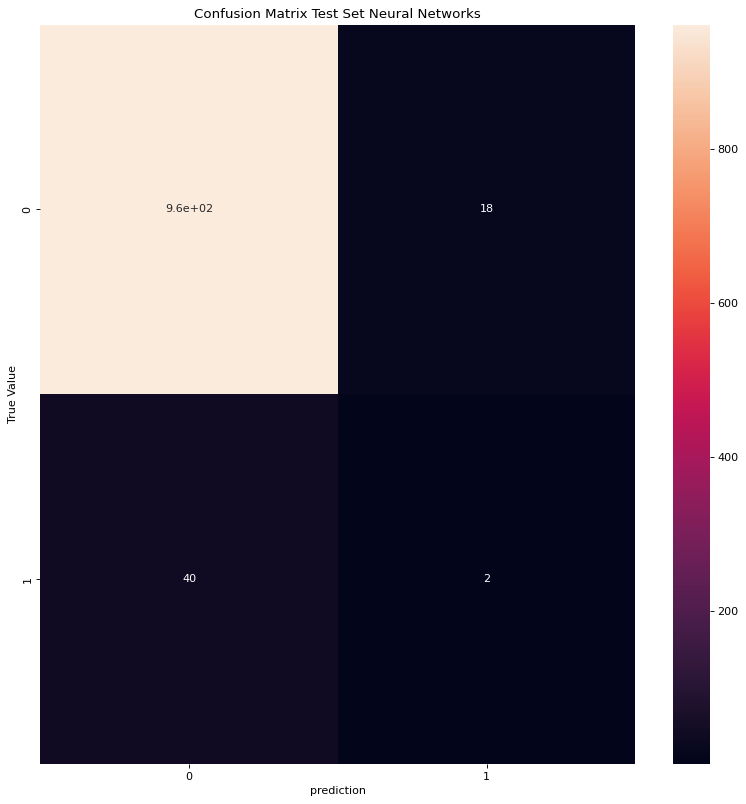

In [34]:
conf_matrix_nn = confusion_matrix(t_te, t_pred_nn_test)
figure(figsize=(12,12) , dpi = 80)
hm = sns.heatmap(conf_matrix_nn, annot=True)
plt.title("Confusion Matrix Test Set Neural Networks")
plt.xlabel("prediction")
plt.ylabel("True Value")
plt.show()

MODEL SELECTION CON SVC

In [35]:
#USO SVC

# Definisco la griglia degli iperparametri per SVC
param_grid_svc = {
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [1,2,3],  # Specifico solo alcuni gradi polinomiali
    'C': [0.1,1,10],
    'class_weight' : [{1: 0.9, 0: 0.1}], # Imposto peso delle classi 
    'gamma': [ 0.1,1,10] 
}

# Crea un modello SVC
svm_model = SVC()

# Configura la Grid Search per SVM
grid_search_svm = GridSearchCV(svm_model, param_grid_svc, cv=5, scoring='f1_macro',verbose=2)

# Esegui la Grid Search sul tuo dataset
grid_search_svm.fit(X_tr_final, t_tr)

# Migliori parametri e miglior modello
best_params_svm = grid_search_svm.best_params_
best_model_svm = grid_search_svm.best_estimator_
best_score_svm = grid_search_svm.best_score_
print("Miglior parametri: ",best_params_svm)
print("Best score: ",best_score_svm)


t_pred_svm_deployment = best_model_svm.predict(X_dep_final)
# Calcolo l'F1-score sul set di deployment
f1_score_dep_svm = f1_score(t_dep, t_pred_svm_deployment, average='macro')
print("F1-score sul deployment set:", f1_score_dep_svm)

#Ora addestramento su deployment set + training set e valutazione prestazione su test set
best_model_svm.fit(X_deployment_test_combined,t_dep_tr_combined)
t_pred_svm_test = best_model_svm.predict(X_tes_final)

# Calcolo l'F1-score sul set di test
f1_score_tes_svm = f1_score(t_te, t_pred_svm_test, average='macro')
print("F1-score su test set:", f1_score_tes_svm)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END C=0.1, class_weight={1: 0.9, 0: 0.1}, degree=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.9, 0: 0.1}, degree=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.9, 0: 0.1}, degree=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.9, 0: 0.1}, degree=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.9, 0: 0.1}, degree=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.9, 0: 0.1}, degree=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.9, 0: 0.1}, degree=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.9, 0: 0.1}, degree=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight={1: 0.9, 0: 0.1}, degree=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight

CONFUSION MATRIX

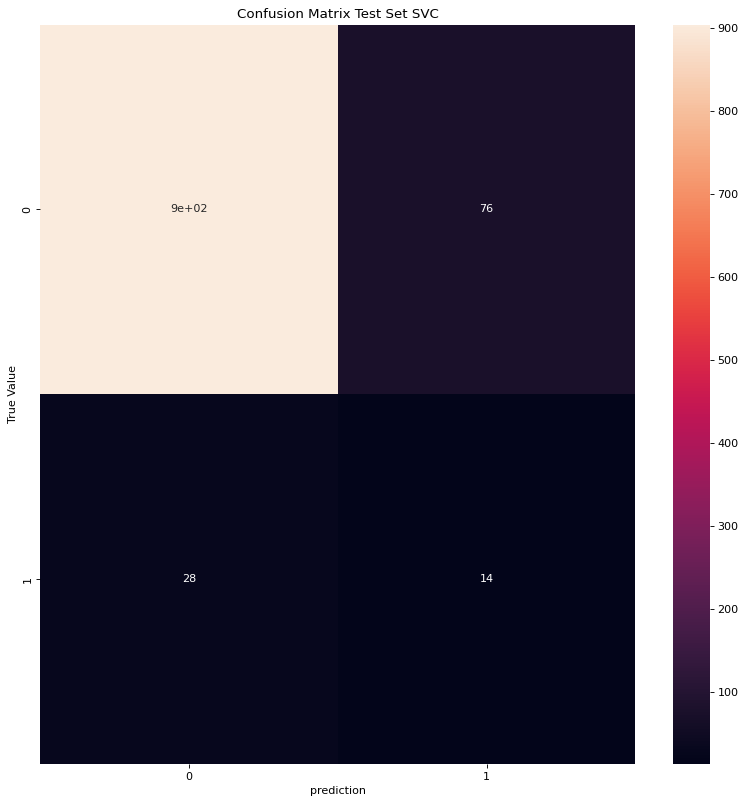

In [36]:
conf_matrix_nn = confusion_matrix(t_te, t_pred_svm_test)
figure(figsize=(12,12) , dpi = 80)
hm = sns.heatmap(conf_matrix_nn, annot=True)
plt.title("Confusion Matrix Test Set SVC")
plt.xlabel("prediction")
plt.ylabel("True Value")
plt.show()